<a href="https://colab.research.google.com/github/AmulPatil/Case-Studies/blob/master/alzheimer_detection_medicalImages_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.3.0 -q

In [ ]:
!pip install kaggle

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amulpatil","key":"1437cf95980f8403b00ec6b74a33bc66"}'}

In [5]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
#! kaggle competitions download -c 'alzheimers-dataset-4-class-of-images'
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 67% 23.0M/34.1M [00:00<00:00, 39.2MB/s]
100% 34.1M/34.1M [00:00<00:00, 69.4MB/s]


In [ ]:
!unzip alzheimers-dataset-4-class-of-images.zip

In [8]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.3.0


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [12]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

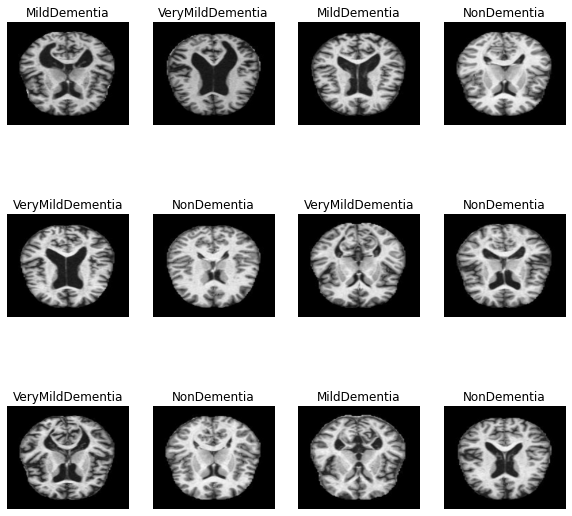

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")



Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. 

In [15]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [16]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

In [17]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [27]:
NUM_IMAGES

[717, 52, 2560, 1792]

# Build the ML Model


In [42]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [43]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [75]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        conv_block(128),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        conv_block(512),
        tf.keras.layers.Dropout(0.3),
        conv_block(1024),
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [76]:
build_model().summary()

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 176, 208, 32)      896       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 176, 208, 32)      9248      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 88, 104, 32)       0         
_________________________________________________________________
sequential_90 (Sequential)   (None, 44, 52, 64)        7392      
_________________________________________________________________
sequential_91 (Sequential)   (None, 22, 26, 128)       27072     
_________________________________________________________________
sequential_92 (Sequential)   (None, 11, 13, 256)       103296    
_________________________________________________________________
dropout_51 (Dropout)         (None, 11, 13, 256)     

In [77]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

In [78]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

Let's fit our model!

In [79]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
257/257 [==============================] - 27s 104ms/step - loss: 1.1109 - auc: 0.7776 - val_loss: 0.9322 - val_auc: 0.8242
Epoch 2/100
257/257 [==============================] - 25s 98ms/step - loss: 0.9860 - auc: 0.8092 - val_loss: 3.2467 - val_auc: 0.7108
Epoch 3/100
257/257 [==============================] - 25s 97ms/step - loss: 0.9671 - auc: 0.8135 - val_loss: 1.1977 - val_auc: 0.5896
Epoch 4/100
257/257 [==============================] - 25s 98ms/step - loss: 0.9530 - auc: 0.8181 - val_loss: 1.0019 - val_auc: 0.7832
Epoch 5/100
257/257 [==============================] - 25s 98ms/step - loss: 0.9568 - auc: 0.8182 - val_loss: 1.8051 - val_auc: 0.5604
Epoch 6/100
257/257 [==============================] - 25s 97ms/step - loss: 0.9431 - auc: 0.8235 - val_loss: 1.1775 - val_auc: 0.6371
Epoch 7/100
257/257 [==============================] - 25s 98ms/step - loss: 0.9314 - auc: 0.8305 - val_loss: 1.5789 - val_auc: 0.8024
Epoch 8/100
257/257 [==============================] -

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

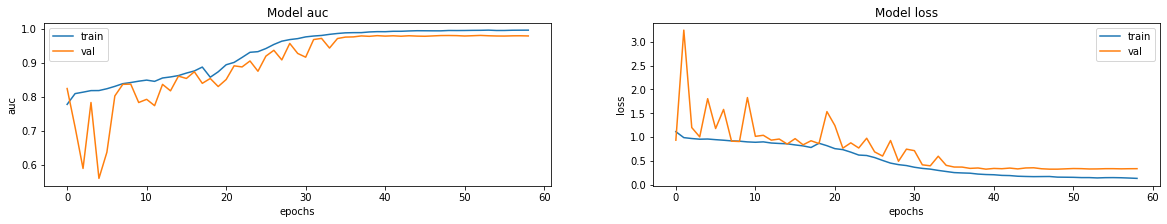

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [84]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [85]:
_ = model.evaluate(test_ds)

80/80 [==============================] - 2s 20ms/step - loss: 1.4372 - auc: 0.8385


<h6>Futher todo:</h6>
Usage of Gradcam to capture the region the model is looking at raw images.<br />
analyse the missclassified images from valid/test folder,and see whither we can introduce augmentation techniques.<br />
Apply stratified k-fold to get optimal results outoff modelling part.<br />
Usage of one cycle poilcy for learning rate scheduler


